
####Fall 2020
#### Machine Learning: Deep Learning HW6
##### Hongtao Wu, Suzanna Sia

This code is provided for Deep Learning class (CS 482/682) Homework 6.

@Copyright Cong Gao, the Johns Hopkins University, cgao11@jhu.edu


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!rm -r -f '/content/HW6_data'
!rm -r -f '/content/unet.py'
!rm -r -f '/content/data.zip'

In [ ]:
!cp '/content/drive/My Drive/Colab Notebooks/Deep Learning/HW6/unet.py' .
!cp '/content/drive/My Drive/Colab Notebooks/Deep Learning/HW6/data.zip' .
!unzip ./data.zip

Streaming output truncated to the last 5000 lines.
  inflating: HW6_data/colorization/train_cor/1139/1139_input.jpg  
 extracting: HW6_data/colorization/train_cor/1139/Icon  
   creating: HW6_data/colorization/train_cor/1435/
 extracting: HW6_data/colorization/train_cor/1435/1435_gray.jpg  
 extracting: HW6_data/colorization/train_cor/1435/Icon  
  inflating: HW6_data/colorization/train_cor/1435/1435_input.jpg  
   creating: HW6_data/colorization/train_cor/543/
 extracting: HW6_data/colorization/train_cor/543/543_gray.jpg  
 extracting: HW6_data/colorization/train_cor/543/Icon  
  inflating: HW6_data/colorization/train_cor/543/543_input.jpg  
   creating: HW6_data/colorization/train_cor/344/
  inflating: HW6_data/colorization/train_cor/344/344_input.jpg  
 extracting: HW6_data/colorization/train_cor/344/344_gray.jpg  
 extracting: HW6_data/colorization/train_cor/344/Icon  
   creating: HW6_data/colorization/train_cor/323/
 extracting: HW6_data/colorization/train_cor/323/323_gray.jpg  


# Question 1

### a) Train UNET

In [ ]:
import os
import numpy as np
import torch.nn as nn

import torch
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms.functional as TF
from torchvision import transforms
from skimage import io
from unet import unet
import json
import matplotlib.pyplot as plt
import time
import random

gpu_boole = torch.cuda.is_available()

# Data Directory
# TODO: Please fill in the directory of the segmentation data here
input_data_dir = './HW6_data/segmentation'

# Mask Json directory
# TODO: Please fill in the path to the mapping.json here
mask_json = './HW6_data/mapping.json'

# Image Transforms
def img_transform(img, mask):
    img = TF.to_tensor(img)
    mask = TF.to_tensor(mask)

    return img, mask


class SegmentationDataset(Dataset):
    def __init__(self, input_dir, op, mask_json_path, transforms=None):
        self.transform = transforms
        self.op = op
        with open(mask_json_path, 'r') as f:
            self.mask = json.load(f)
        self.mask_num = len(self.mask)  # There are 8 categories: grey, dark grey, and black
        self.mask_value = [value for value in self.mask.values()]
        self.mask_value.sort()
        try:
            if self.op == 'train':
                self.data_dir = os.path.join(input_dir, 'train')
            elif self.op == 'val':
                self.data_dir = os.path.join(input_dir, 'validation')
            elif self.op == 'test':
                self.data_dir = os.path.join(input_dir, 'test')
        except ValueError:
            print('op should be either train, val or test!')

    def __len__(self):
        return len(next(os.walk(self.data_dir))[1])

    def __getitem__(self, idx):
        img_name = str(idx) + '_input.jpg'
        mask_name = str(idx) + '_mask.png'
        img = io.imread(os.path.join(self.data_dir, str(idx), img_name))
        mask = io.imread(os.path.join(self.data_dir, str(idx), mask_name))
        h, w = mask.shape

        # Convert grey-scale label to one-hot encoding
        new_mask = np.zeros((h, w, self.mask_num))
        for idx in range(self.mask_num):
            new_mask[:, :, idx] = mask == self.mask_value[idx]

        # Transform image and mask
        if self.transform:
            img, mask = self.transform(img, new_mask)

        # Use dictionary to output
        sample = {'img': img, 'mask': mask}

        return sample

In [ ]:
def DSC_num_batch(A,B):
  return 2*torch.sum(torch.mul(A, B), dim=(1,2,3))

def DSC_den_batch(A,B):
  return torch.sum((torch.pow(A, 2) + torch.pow(B, 2)), dim=(1,2,3))

def DSC_batch(A,B):
  return (DSC_num_batch(A,B) / DSC_den_batch(A,B)).mean()

def True_DSC_batch(A,B):
  n = 2*torch.sum(torch.mul(A, B), dim=(1,2,3)).float()
  d = torch.sum(A + B, dim=(1,2,3)).float()
  return (n / d).mean()

def DSC_loss(A,B):
  return 1 + -1.0*DSC_batch(A,B)

In [ ]:
def train_eval(loss_metric, verbose = 1):
    loss_sum = 0
    total = 0
    with torch.no_grad():
        for sample_batch in train_loader:
            images, masks = sample_batch['img'], sample_batch['mask']
            if gpu_boole:
                images, masks = images.cuda(), masks.cuda()

            _, outputs = net(images)
            # probs = net.softmax(logits)
            loss_sum += loss_metric(outputs,masks)
            total += 1
        
    avg_loss = loss_sum.cpu().data.numpy().item() / total
    if verbose:
        print('Train loss: %f' % (avg_loss))

    return avg_loss

def valid_eval(loss_metric, verbose = 1):
    loss_sum = 0
    total = 0
    with torch.no_grad():
        for sample_batch in val_loader:
            images, masks = sample_batch['img'], sample_batch['mask']
            if gpu_boole:
                images, masks = images.cuda(), masks.cuda()

            _, outputs = net(images)
            loss_sum += loss_metric(outputs,masks)
            total += 1
        
    avg_loss = loss_sum.cpu().data.numpy().item() / total
    if verbose:
        print('Validation loss: %f' % (avg_loss))

    return avg_loss


def test_acc():
    acc_sum = 0
    total = 0
    with torch.no_grad():
        for sample_batch in test_loader:
            images, masks = sample_batch['img'], sample_batch['mask']
            if gpu_boole:
                images, masks = images.cuda(), masks.cuda()

            _, outputs = net(images)
            pred = torch.argmax(outputs, dim=1)
            class_pred = torch.nn.functional.one_hot(pred, num_classes=8).permute(0,3,1,2)

            acc_sum += True_DSC_batch(class_pred, masks)
            total += 1
        
    return acc_sum.cpu().data.numpy().item() / total

In [ ]:
class EarlyStopping:
    """Stops training if validation loss doesn't improve after certain number of epochs"""
    def __init__(self, patience=7, path='checkpoint.pt'):
        self.patience = patience
        self.counter = 0
        self.early_stop = False
        self.val_loss_min = np.Inf
        self.path = path

    def __call__(self, val_loss, model):
        if val_loss < self.val_loss_min:
            self.save_checkpoint(val_loss, model)
            self.counter = 0
        else:
            self.counter += 1
            print('Early Stopping counter: ', self.counter, ' out of ', self.patience)
            if self.counter >= self.patience:
                self.early_stop = True

    def save_checkpoint(self, val_loss, model):
        '''Saves model when validation loss decreases.'''
        print('Validation loss decreased (', round(self.val_loss_min, 6), ' --> ', round(val_loss, 6), ').  Saving model ...')
        torch.save(model.state_dict(), self.path)
        self.val_loss_min = val_loss

In [ ]:
def train(net, epochs, loss_metric, optimizer, patience=7, save_path='checkpoint.pt'):
    #defining batch train loss recording arrays for later visualization/plotting:
    train_loss_store = []
    valid_loss_store = []
    
    early_stopping = EarlyStopping(patience=patience, path=save_path)

    print("Starting Training")

    #training loop:
    for epoch in range(epochs):
        time1 = time.time() #timekeeping

        for i, sample_batch in enumerate(train_loader):
            images, masks = sample_batch['img'], sample_batch['mask']

            if gpu_boole:
                images, masks = images.cuda(), masks.cuda()

            #loss calculation and gradient update:
            optimizer.zero_grad()
            _, outputs = net.forward(images)
            loss = loss_metric(outputs,masks)
            loss.backward()
                          
            #perform update:
            optimizer.step()

        print("Epoch",epoch+1,':')
        train_loss = train_eval(loss_metric)
        valid_loss = valid_eval(loss_metric)

        train_loss_store.append(train_loss)
        valid_loss_store.append(valid_loss)

        # early stoppy to prevent overfitting
        early_stopping(valid_loss, net)
        
        if early_stopping.early_stop:
            print("Early stopping")
            break

        time2 = time.time() #timekeeping
        print('Elapsed time for epoch:',round(time2 - time1),'s')
        print('ETA of completion:',round((time2 - time1)*(epochs - epoch - 1)/60, 1),'minutes')
        print()

    return train_loss_store, valid_loss_store

In [ ]:
######################## Hyperparameters #################################
# These are SUGGESTED hyperparameters - please feel free to use what works for you.
# Batch size can be changed if it does not match your memory, please state your batch step_size
# in your report.
train_batch_size = 10
validation_batch_size = 10
learning_rate = 0.001

# This num_epochs is probably too much, design an early stopping method.
num_epochs = 200

In [ ]:
net = unet(useBN=True)
if gpu_boole:
  net = net.cuda()

optimizer = torch.optim.Adam(net.parameters(), lr=learning_rate)
loss_metric = DSC_loss

segmentation_train = SegmentationDataset(input_data_dir, 'train', mask_json, img_transform)
segmentation_test = SegmentationDataset(input_data_dir, 'test', mask_json, img_transform)
segmentation_val = SegmentationDataset(input_data_dir, 'val', mask_json, img_transform)

train_loader = DataLoader(segmentation_train, batch_size=train_batch_size, shuffle=True)
test_loader = DataLoader(segmentation_test, batch_size=validation_batch_size, shuffle=False)
val_loader = DataLoader(segmentation_val, batch_size=validation_batch_size, shuffle=False)

In [ ]:
train_loss_store, valid_loss_store = train(net, num_epochs, loss_metric, optimizer, save_path='checkpoint_a.pt')

Starting Training
Epoch 1 :
Train loss: 0.738342
Validation loss: 0.742157
Validation loss decreased ( inf  -->  0.742157 ).  Saving model ...
Elapsed time for epoch: 9 s
ETA of completion: 28.5 minutes

Epoch 2 :
Train loss: 0.732309
Validation loss: 0.743647
Early Stopping counter:  1  out of  7
Elapsed time for epoch: 8 s
ETA of completion: 26.8 minutes

Epoch 3 :
Train loss: 0.725470
Validation loss: 0.740342
Validation loss decreased ( 0.742157  -->  0.740342 ).  Saving model ...
Elapsed time for epoch: 8 s
ETA of completion: 26.7 minutes

Epoch 4 :
Train loss: 0.721894
Validation loss: 0.736632
Validation loss decreased ( 0.740342  -->  0.736632 ).  Saving model ...
Elapsed time for epoch: 8 s
ETA of completion: 26.8 minutes

Epoch 5 :
Train loss: 0.720169
Validation loss: 0.737968
Early Stopping counter:  1  out of  7
Elapsed time for epoch: 8 s
ETA of completion: 26.5 minutes

Epoch 6 :
Train loss: 0.709791
Validation loss: 0.734849
Validation loss decreased ( 0.736632  -->  0.

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:11: UserWarning: Mixed memory format inputs detected while calling the operator. The operator will output channels_last tensor even if some of the inputs are not in channels_last format. (Triggered internally at  /pytorch/aten/src/ATen/native/TensorIterator.cpp:924.)
  # This is added back by InteractiveShellApp.init_path()


Average Test DICE Score:  0.57262


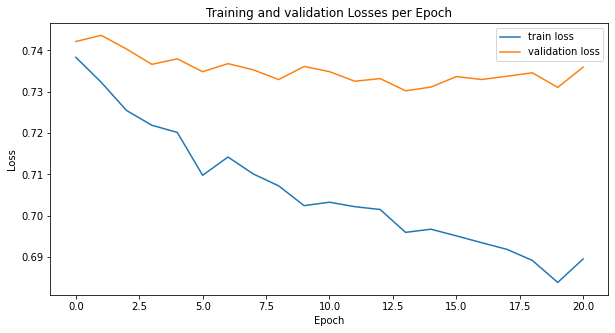

In [ ]:
print("Average Test DICE Score: ", round(test_acc(), 5))

fig = plt.figure(figsize=(10,5))
plt.plot(train_loss_store, label='train loss')
plt.plot(valid_loss_store, label='validation loss')
plt.title("Training and validation Losses per Epoch")
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

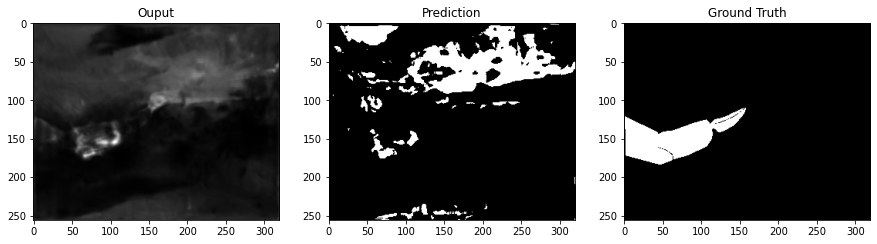

In [ ]:
sample_batch = next(iter(val_loader))
images, masks = sample_batch['img'], sample_batch['mask']

i, j = 0,1


_, outputs = net(images.cuda())
pred = torch.argmax(outputs, dim=1)
new_pred = torch.nn.functional.one_hot(pred, num_classes=8).permute(0,3,1,2)

fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15,15))
ax1.imshow(outputs[i][j].cpu().detach().numpy(), cmap='gray')
ax1.set_title("Ouput")
ax2.imshow(new_pred[i][j].cpu().detach().numpy(), cmap='gray')
ax2.set_title("Prediction")
ax3.imshow(masks[i][j].detach().numpy(), cmap='gray')
ax3.set_title("Ground Truth")

plt.show()

### b) Data augmentations

In [ ]:
######################## Hyperparameters #################################
# These are SUGGESTED hyperparameters - please feel free to use what works for you.
# Batch size can be changed if it does not match your memory, please state your batch step_size
# in your report.
train_batch_size = 10
validation_batch_size = 10
learning_rate = 0.001

# This num_epochs is probably too much, design an early stopping method.
num_epochs = 200

In [ ]:
def segmentation_transform(img, mask):
    img = TF.to_tensor(img)
    mask = TF.to_tensor(mask)

    if random.random() > 0.5:
        img = TF.hflip(img)
        mask = TF.hflip(mask)

    if random.random() > 0.5:
        img = TF.vflip(img)
        mask = TF.vflip(mask)

    return img, mask

In [ ]:
net = unet(useBN=True)
if gpu_boole:
  net = net.cuda()

optimizer = torch.optim.Adam(net.parameters(), lr=learning_rate)
loss_metric = DSC_loss

segmentation_train = SegmentationDataset(input_data_dir, 'train', mask_json, segmentation_transform)
segmentation_test = SegmentationDataset(input_data_dir, 'test', mask_json, img_transform)
segmentation_val = SegmentationDataset(input_data_dir, 'val', mask_json, img_transform)

train_loader = DataLoader(segmentation_train, batch_size=train_batch_size, shuffle=True)
test_loader = DataLoader(segmentation_test, batch_size=validation_batch_size, shuffle=False)
val_loader = DataLoader(segmentation_val, batch_size=validation_batch_size, shuffle=False)

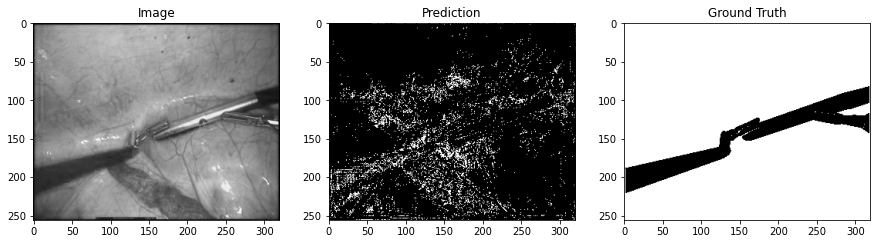

In [ ]:
sample_batch = next(iter(train_loader))
images, masks = sample_batch['img'], sample_batch['mask']

i, j = 0,0


_, outputs = net(images.cuda())
pred = torch.argmax(outputs, dim=1)
new_pred = torch.nn.functional.one_hot(pred, num_classes=8).permute(0,3,1,2)

fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15,15))
ax1.imshow(images[i][0].cpu().detach().numpy(), cmap='gray')
ax1.set_title("Image")
ax2.imshow(new_pred[i][j].cpu().detach().numpy(), cmap='gray')
ax2.set_title("Prediction")
ax3.imshow(masks[i][j].detach().numpy(), cmap='gray')
ax3.set_title("Ground Truth")

plt.show()

In [22]:
train_loss_store, valid_loss_store = train(net, num_epochs, loss_metric, optimizer, patience=50, save_path='checkpoint_b.pt')

Starting Training
Epoch 1 :
Train loss: 0.741923
Validation loss: 0.747738
Validation loss decreased ( inf  -->  0.747738 ).  Saving model ...
Elapsed time for epoch: 28 s
ETA of completion: 93.5 minutes

Epoch 2 :
Train loss: 0.731431
Validation loss: 0.740943
Validation loss decreased ( 0.747738  -->  0.740943 ).  Saving model ...
Elapsed time for epoch: 29 s
ETA of completion: 94.5 minutes

Epoch 3 :
Train loss: 0.723513
Validation loss: 0.740089
Validation loss decreased ( 0.740943  -->  0.740089 ).  Saving model ...
Elapsed time for epoch: 29 s
ETA of completion: 95.1 minutes

Epoch 4 :
Train loss: 0.724368
Validation loss: 0.739127
Validation loss decreased ( 0.740089  -->  0.739127 ).  Saving model ...
Elapsed time for epoch: 29 s
ETA of completion: 95.7 minutes

Epoch 5 :
Train loss: 0.722328
Validation loss: 0.740228
Early Stopping counter:  1  out of  50
Elapsed time for epoch: 29 s
ETA of completion: 93.5 minutes

Epoch 6 :
Train loss: 0.720186
Validation loss: 0.739138
Earl

Average Test DICE Score:  0.58154


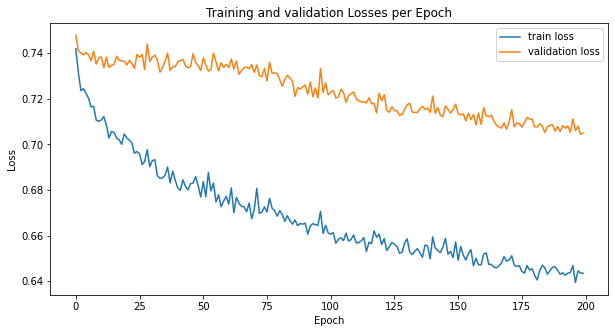

In [23]:
print("Average Test DICE Score: ", round(test_acc(), 5))

fig = plt.figure(figsize=(10,5))
plt.plot(train_loss_store, label='train loss')
plt.plot(valid_loss_store, label='validation loss')
plt.title("Training and validation Losses per Epoch")
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

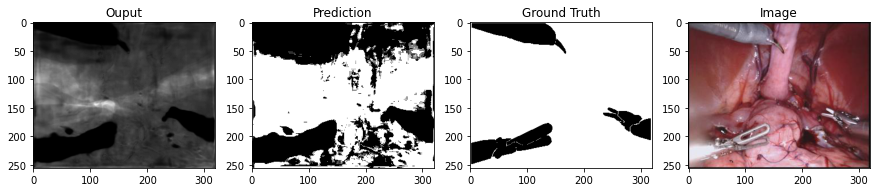

In [26]:
# sample_batch = next(iter(val_loader))
images, masks = sample_batch['img'], sample_batch['mask']

i, j = 1,0

_, outputs = net(images.cuda())
pred = torch.argmax(outputs, dim=1)
new_pred = torch.nn.functional.one_hot(pred, num_classes=8).permute(0,3,1,2)

fig, (ax1, ax2, ax3, ax4) = plt.subplots(1, 4, figsize=(15,15))
ax1.imshow(outputs[i][j].cpu().detach().numpy(), cmap='gray')
ax1.set_title("Ouput")
ax2.imshow(new_pred[i][j].cpu().detach().numpy(), cmap='gray')
ax2.set_title("Prediction")
ax3.imshow(masks[i][j].detach().numpy(), cmap='gray')
ax3.set_title("Ground Truth")
ax4.imshow(images[i].permute(1,2,0).detach().numpy(), cmap='gray')
ax4.set_title("Image")

plt.show()

### c) Change Hyper Parameters

In [44]:
######################## Hyperparameters #################################
# These are SUGGESTED hyperparameters - please feel free to use what works for you.
# Batch size can be changed if it does not match your memory, please state your batch step_size
# in your report.
train_batch_size = 10
validation_batch_size = 10
learning_rate = 0.002

# This num_epochs is probably too much, design an early stopping method.
num_epochs = 400

In [45]:
net = unet(useBN=True)
if gpu_boole:
  net = net.cuda()

optimizer = torch.optim.Adam(net.parameters(), lr=learning_rate)
loss_metric = DSC_loss

segmentation_train = SegmentationDataset(input_data_dir, 'train', mask_json, segmentation_transform)
segmentation_test = SegmentationDataset(input_data_dir, 'test', mask_json, img_transform)
segmentation_val = SegmentationDataset(input_data_dir, 'val', mask_json, img_transform)

train_loader = DataLoader(segmentation_train, batch_size=train_batch_size, shuffle=True)
test_loader = DataLoader(segmentation_test, batch_size=validation_batch_size, shuffle=False)
val_loader = DataLoader(segmentation_val, batch_size=validation_batch_size, shuffle=False)

In [46]:
train_loss_store, valid_loss_store = train(net, num_epochs, loss_metric, optimizer, patience=50, save_path='checkpoint_c.pt')

Starting Training
Epoch 1 :
Train loss: 0.735715
Validation loss: 0.743201
Validation loss decreased ( inf  -->  0.743201 ).  Saving model ...
Elapsed time for epoch: 28 s
ETA of completion: 186.6 minutes

Epoch 2 :
Train loss: 0.727945
Validation loss: 0.739393
Validation loss decreased ( 0.743201  -->  0.739393 ).  Saving model ...
Elapsed time for epoch: 28 s
ETA of completion: 188.0 minutes

Epoch 3 :
Train loss: 0.723002
Validation loss: 0.738433
Validation loss decreased ( 0.739393  -->  0.738433 ).  Saving model ...
Elapsed time for epoch: 28 s
ETA of completion: 185.1 minutes

Epoch 4 :
Train loss: 0.725285
Validation loss: 0.739334
Early Stopping counter:  1  out of  50
Elapsed time for epoch: 28 s
ETA of completion: 182.6 minutes

Epoch 5 :
Train loss: 0.720763
Validation loss: 0.736880
Validation loss decreased ( 0.738433  -->  0.73688 ).  Saving model ...
Elapsed time for epoch: 29 s
ETA of completion: 191.6 minutes

Epoch 6 :
Train loss: 0.718296
Validation loss: 0.736070


Average Test DICE Score:  0.6294


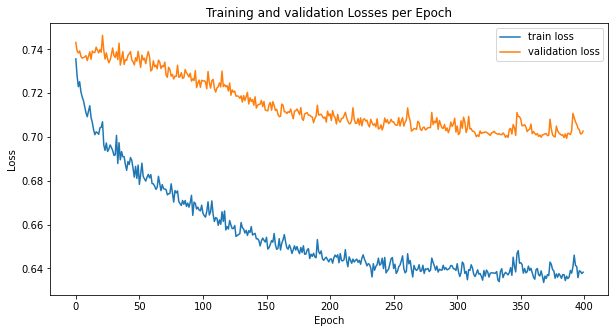

In [47]:
print("Average Test DICE Score: ", round(test_acc(), 5))

fig = plt.figure(figsize=(10,5))
plt.plot(train_loss_store, label='train loss')
plt.plot(valid_loss_store, label='validation loss')
plt.title("Training and validation Losses per Epoch")
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

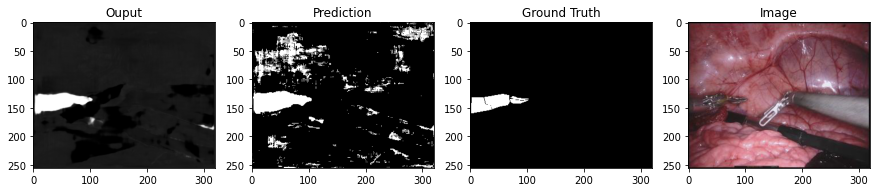

In [48]:
sample_batch = next(iter(val_loader))
images, masks = sample_batch['img'], sample_batch['mask']

i, j = 1,1

_, outputs = net(images.cuda())
pred = torch.argmax(outputs, dim=1)
new_pred = torch.nn.functional.one_hot(pred, num_classes=8).permute(0,3,1,2)

fig, (ax1, ax2, ax3, ax4) = plt.subplots(1, 4, figsize=(15,15))
ax1.imshow(outputs[i][j].cpu().detach().numpy(), cmap='gray')
ax1.set_title("Ouput")
ax2.imshow(new_pred[i][j].cpu().detach().numpy(), cmap='gray')
ax2.set_title("Prediction")
ax3.imshow(masks[i][j].detach().numpy(), cmap='gray')
ax3.set_title("Ground Truth")
ax4.imshow(images[i].permute(1,2,0).detach().numpy(), cmap='gray')
ax4.set_title("Image")

plt.show()

### d) Colorization Training

In [63]:
input_dir_cor = './HW6_data/colorization'

class ColorizationDataset(Dataset):
    def __init__(self, input_dir, op, transforms=None):
        self.transform = transforms
        self.op = op

        try:
            if self.op == 'train':
                self.data_dir = os.path.join(input_dir, 'train_cor')
            elif self.op == 'val':
                self.data_dir = os.path.join(input_dir, 'validation_cor')
        except ValueError:
            print('op should be either train, val or test!')

    def __len__(self):
        return len(next(os.walk(self.data_dir))[1])

    def __getitem__(self, idx):
        gray_name = str(idx) + '_gray.jpg'
        cor_name = str(idx) + '_input.jpg'
        gray = io.imread(os.path.join(self.data_dir, str(idx), gray_name))
        cor = io.imread(os.path.join(self.data_dir, str(idx), cor_name))

        # Transform gray and color
        if self.transform:
            gray, cor = self.transform(gray, cor)

        # Use dictionary to output
        sample = {'gray': gray, 'cor': cor}

        return sample

In [64]:
# attach a prediction layer to the unet to reformat its output
class Net(nn.Module):
  def __init__(self):
    super(Net, self).__init__()

    # unet
    self.unet = unet(useBN=True)

    # reshape output
    self.pred = nn.Conv2d(8, 3, kernel_size=(1,1))

                
  def forward(self, input_data):
    out, _ = self.unet(input_data)
    out = self.pred(out)
    return out #returns class probabilities for each image

In [65]:
def train_eval_cor(loss_metric, verbose = 1):
    loss_sum = 0
    total = 0
    with torch.no_grad():
        for sample_batch in train_loader:
            grays, cors = sample_batch['gray'], sample_batch['cor']
            if gpu_boole:
                grays, cors = grays.cuda(), cors.cuda()

            outputs = net(grays)
            loss_sum += loss_metric(outputs,cors)
            total += 1
        
    avg_loss = loss_sum.cpu().data.numpy().item() / total
    if verbose:
        print('Train loss: %f' % (avg_loss))

    return avg_loss

def valid_eval_cor(loss_metric, verbose = 1):
    loss_sum = 0
    total = 0
    with torch.no_grad():
        for sample_batch in val_loader:
            grays, cors = sample_batch['gray'], sample_batch['cor']
            if gpu_boole:
                grays, cors = grays.cuda(), cors.cuda()

            outputs = net(grays)
            loss_sum += loss_metric(outputs,cors)
            total += 1
        
    avg_loss = loss_sum.cpu().data.numpy().item() / total
    if verbose:
        print('Validation loss: %f' % (avg_loss))

    return avg_loss

In [66]:
def train_cor(net, epochs, loss_metric, optimizer, patience=7, save_path='checkpoint.pt'):
    #defining batch train loss recording arrays for later visualization/plotting:
    train_loss_store = []
    valid_loss_store = []
    
    early_stopping = EarlyStopping(patience=patience, path=save_path)

    print("Starting Training")

    #training loop:
    for epoch in range(epochs):
        time1 = time.time() #timekeeping

        for i, sample_batch in enumerate(train_loader):
            grays, cors = sample_batch['gray'], sample_batch['cor']

            if gpu_boole:
                grays, cors = grays.cuda(), cors.cuda()

            #loss calculation and gradient update:
            optimizer.zero_grad()
            outputs = net(grays)
            loss = loss_metric(outputs,cors)
            loss.backward()
                          
            #perform update:
            optimizer.step()

        print("Epoch",epoch+1,':')
        train_loss = train_eval_cor(loss_metric)
        valid_loss = valid_eval_cor(loss_metric)

        train_loss_store.append(train_loss)
        valid_loss_store.append(valid_loss)

        # early stoppy to prevent overfitting
        early_stopping(valid_loss, net)
        
        if early_stopping.early_stop:
            print("Early stopping")
            break

        time2 = time.time() #timekeeping
        print('Elapsed time for epoch:',round(time2 - time1),'s')
        print('ETA of completion:',round((time2 - time1)*(epochs - epoch - 1)/60, 1),'minutes')
        print()

    return train_loss_store, valid_loss_store

In [67]:
# Image Transforms
def cor_transform(gray, cor):
    gray = TF.to_tensor(gray).repeat(3,1,1)
    cor = TF.to_tensor(cor)

    return gray, cor

In [68]:
######################## Hyperparameters #################################
# These are SUGGESTED hyperparameters - please feel free to use what works for you.
# Batch size can be changed if it does not match your memory, please state your batch step_size
# in your report.
train_batch_size = 10
validation_batch_size = 10
learning_rate = 0.001

# This num_epochs is probably too much, design an early stopping method.
num_epochs = 30

In [69]:
net = Net()
if gpu_boole:
  net = net.cuda()

optimizer = torch.optim.Adam(net.parameters(), lr=learning_rate)
loss_metric = nn.MSELoss()

colorization_train = ColorizationDataset(input_dir_cor, 'train', cor_transform)
colorization_val = ColorizationDataset(input_dir_cor, 'val', cor_transform)

train_loader = DataLoader(colorization_train, batch_size=train_batch_size, shuffle=True)
val_loader = DataLoader(colorization_val, batch_size=validation_batch_size, shuffle=False)

In [70]:
!cp -r '/content/HW6_data/colorization/train_cor/0' '/content/HW6_data/colorization/validation_cor/'

In [71]:
train_loss_store, valid_loss_store = train_cor(net, num_epochs, loss_metric, optimizer, patience=7, save_path='checkpoint_d.pt')

Starting Training
Epoch 1 :
Train loss: 0.001796
Validation loss: 0.003112
Validation loss decreased ( inf  -->  0.003112 ).  Saving model ...
Elapsed time for epoch: 23 s
ETA of completion: 11.3 minutes

Epoch 2 :
Train loss: 0.001354
Validation loss: 0.002851
Validation loss decreased ( 0.003112  -->  0.002851 ).  Saving model ...
Elapsed time for epoch: 23 s
ETA of completion: 10.9 minutes

Epoch 3 :
Train loss: 0.001292
Validation loss: 0.002698
Validation loss decreased ( 0.002851  -->  0.002698 ).  Saving model ...
Elapsed time for epoch: 23 s
ETA of completion: 10.5 minutes

Epoch 4 :
Train loss: 0.001260
Validation loss: 0.003251
Early Stopping counter:  1  out of  7
Elapsed time for epoch: 23 s
ETA of completion: 10.1 minutes

Epoch 5 :
Train loss: 0.001095
Validation loss: 0.002248
Validation loss decreased ( 0.002698  -->  0.002248 ).  Saving model ...
Elapsed time for epoch: 23 s
ETA of completion: 9.7 minutes

Epoch 6 :
Train loss: 0.000988
Validation loss: 0.002630
Early 

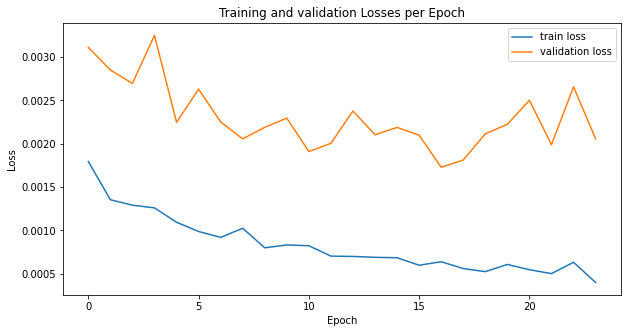

In [72]:
fig = plt.figure(figsize=(10,5))
plt.plot(train_loss_store, label='train loss')
plt.plot(valid_loss_store, label='validation loss')
plt.title("Training and validation Losses per Epoch")
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

print()

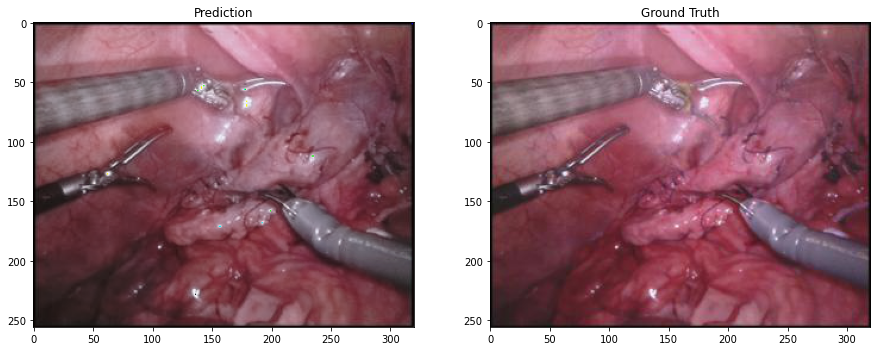

In [74]:
sample_batch = next(iter(val_loader))
grays, cors = sample_batch['gray'], sample_batch['cor']

i = 4

outputs = net(grays.cuda())

img = TF.to_pil_image(cors[i])
pred = TF.to_pil_image(outputs[i].cpu().detach())

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15,15))
ax1.imshow(pred)
ax1.set_title("Prediction")
ax2.imshow(img)
ax2.set_title("Ground Truth")

plt.show()

### e) Retrain Colorization on Segmentation 

In [87]:
######################## Hyperparameters #################################
# These are SUGGESTED hyperparameters - please feel free to use what works for you.
# Batch size can be changed if it does not match your memory, please state your batch step_size
# in your report.
train_batch_size = 20
validation_batch_size = 10
learning_rate = 0.002

# This num_epochs is probably too much, design an early stopping method.
num_epochs = 400

In [88]:
model = Net()
model.load_state_dict(torch.load('/content/checkpoint_d.pt'))

<All keys matched successfully>

In [89]:
net = model.unet
if gpu_boole:
  net = net.cuda()

optimizer = torch.optim.Adam(net.parameters(), lr=learning_rate)
loss_metric = DSC_loss

segmentation_train = SegmentationDataset(input_data_dir, 'train', mask_json, segmentation_transform)
segmentation_test = SegmentationDataset(input_data_dir, 'test', mask_json, img_transform)
segmentation_val = SegmentationDataset(input_data_dir, 'val', mask_json, img_transform)

train_loader = DataLoader(segmentation_train, batch_size=train_batch_size, shuffle=True)
test_loader = DataLoader(segmentation_test, batch_size=validation_batch_size, shuffle=False)
val_loader = DataLoader(segmentation_val, batch_size=validation_batch_size, shuffle=False)

In [90]:
train_loss_store, valid_loss_store = train(net, num_epochs, loss_metric, optimizer, patience=50, save_path='checkpoint_e.pt')

Starting Training
Epoch 1 :
Train loss: 0.859621
Validation loss: 0.759381
Validation loss decreased ( inf  -->  0.759381 ).  Saving model ...
Elapsed time for epoch: 29 s
ETA of completion: 193.2 minutes

Epoch 2 :
Train loss: 0.838864
Validation loss: 0.747490
Validation loss decreased ( 0.759381  -->  0.74749 ).  Saving model ...
Elapsed time for epoch: 30 s
ETA of completion: 196.5 minutes

Epoch 3 :
Train loss: 0.823121
Validation loss: 0.742587
Validation loss decreased ( 0.74749  -->  0.742587 ).  Saving model ...
Elapsed time for epoch: 29 s
ETA of completion: 189.0 minutes

Epoch 4 :
Train loss: 0.820374
Validation loss: 0.743013
Early Stopping counter:  1  out of  50
Elapsed time for epoch: 29 s
ETA of completion: 189.2 minutes

Epoch 5 :
Train loss: 0.815738
Validation loss: 0.745173
Early Stopping counter:  2  out of  50
Elapsed time for epoch: 30 s
ETA of completion: 198.6 minutes

Epoch 6 :
Train loss: 0.811394
Validation loss: 0.743895
Early Stopping counter:  3  out of 

Average Test DICE Score:  0.51051


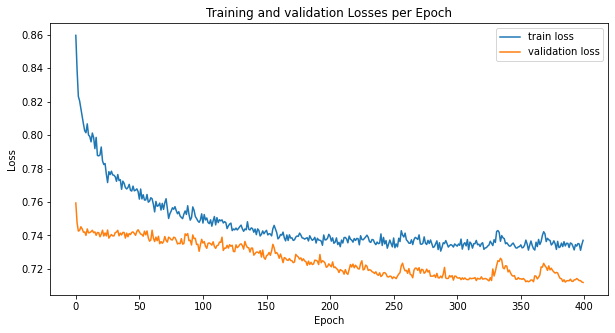

In [91]:
print("Average Test DICE Score: ", round(test_acc(), 5))

fig = plt.figure(figsize=(10,5))
plt.plot(train_loss_store, label='train loss')
plt.plot(valid_loss_store, label='validation loss')
plt.title("Training and validation Losses per Epoch")
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

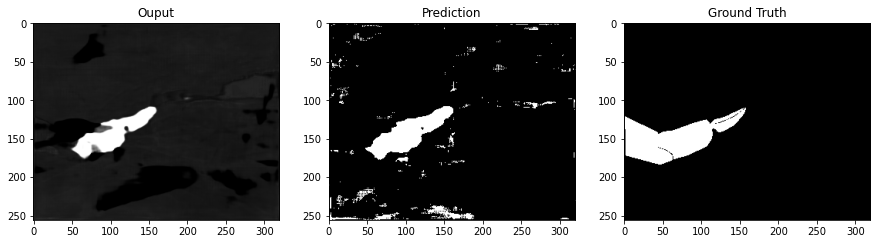

In [92]:
sample_batch = next(iter(val_loader))
images, masks = sample_batch['img'], sample_batch['mask']

i, j = 0,1


_, outputs = net(images.cuda())
pred = torch.argmax(outputs, dim=1)
new_pred = torch.nn.functional.one_hot(pred, num_classes=8).permute(0,3,1,2)

fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15,15))
ax1.imshow(outputs[i][j].cpu().detach().numpy(), cmap='gray')
ax1.set_title("Ouput")
ax2.imshow(new_pred[i][j].cpu().detach().numpy(), cmap='gray')
ax2.set_title("Prediction")
ax3.imshow(masks[i][j].detach().numpy(), cmap='gray')
ax3.set_title("Ground Truth")

plt.show()

In [93]:
!cp '/content/checkpoint_*.pt' '/content/drive/My Drive/Colab Notebooks/Deep Learning/HW6'

cp: cannot stat '/content/checkpoint_*.pt': No such file or directory
